https://huggingface.co/datasets/cnamuangtoun/resume-job-description-fit/tree/main

cnamuangtoun/resume-job-description-fit

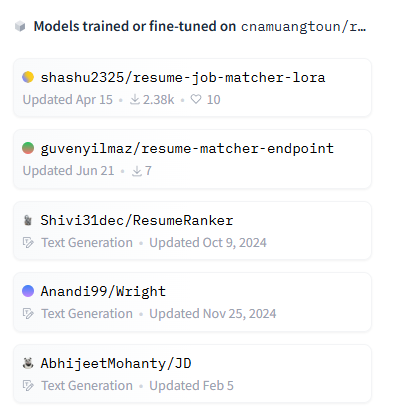

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/AI-ML Self Learning/next_horizon/resume_job_recommendation/cnamuangtoun-resume-job-description-fit/train.csv')
df_train

,resume_text,job_description_text,label
0,SummaryHighly motivated Sales Associate with e...,Net2Source Inc. is an award-winning total work...,No Fit
1,Professional SummaryCurrently working with Cat...,At Salas OBrien we tell our clients that were ...,No Fit
2,SummaryI started my construction career in Jun...,Schweitzer Engineering Laboratories (SEL) Infr...,No Fit
3,SummaryCertified Electrical Foremanwith thirte...,"Mizick Miller & Company, Inc. is looking for a...",No Fit
4,SummaryWith extensive experience in business/r...,Life at Capgemini\nCapgemini supports all aspe...,No Fit
...,...,...,...
6236,SummaryResults-driven Data Entry Clerk with ex...,"Hi,\nHope you are doing great today. Please fi...",Good Fit
6237,Professional SummaryWith the attitude of learn...,Job Title: DHT - Front End Software Engineer W...,Good Fit
6238,Summary• \nOver\nThree years of extensi...,LHH Recruitment Solutions is looking for a Sof...,Good Fit
6239,ProfileAbility to prioritize and multi-task in...,Our client is a growing Medical Device company...,Good Fit


In [4]:
df_test = pd.read_csv('/content/drive/MyDrive/AI-ML Self Learning/next_horizon/resume_job_recommendation/cnamuangtoun-resume-job-description-fit/test.csv')
df_test

,resume_text,job_description_text,label
0,Summary7+ years of experience as a BI develope...,Key Responsibilities:Create intricate wiring n...,No Fit
1,Professional BackgroundAnalyst versed in data ...,Personal development and becoming the best you...,No Fit
2,Executive ProfileDedicated professional with t...,"Location: Tampa, FL\nExp: 7-10 Yrs\nSPOC: Tush...",No Fit
3,"Summarytyee\nHighlightsMicrosoft Excel, Word, ...","Primary Location: Melbourne, Florida\nV-Soft C...",No Fit
4,SummaryEIT certified Engineer and ASTQB Certif...,At Oregon Specialty Group the Accounting & Pay...,No Fit
...,...,...,...
1754,SummaryHighly motivated Sales Associate with e...,"Position Type: Full-Time, W2 Direct Hire. (Mus...",Good Fit
1755,SummaryWireless communications engineer with e...,"Location: Tampa, FL\nExp: 7-10 Yrs\nSPOC: Tush...",Good Fit
1756,Professional ProfileCapable International Tax ...,"Backed by a leading growth equity firm, an LA ...",Good Fit
1757,SummaryData Engineeringwith experience in Desi...,Allergan Data Labs is on a mission to transfor...,Good Fit


### EDA

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6241 entries, 0 to 6240
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   resume_text           6241 non-null   object
 1   job_description_text  6241 non-null   object
 2   label                 6241 non-null   object
dtypes: object(3)
memory usage: 146.4+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759 entries, 0 to 1758
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   resume_text           1759 non-null   object
 1   job_description_text  1759 non-null   object
 2   label                 1759 non-null   object
dtypes: object(3)
memory usage: 41.4+ KB


In [7]:
df_train['resume_text'].nunique()

642

In [8]:
df_train['job_description_text'].nunique()

280

In [9]:
df_train['label'].value_counts()

,count
label,
No Fit,3143
Potential Fit,1556
Good Fit,1542


## OpenAI Embeddings and Cosine Similarity-Based Prediction

This section uses OpenAI's text-embedding-3-small model to generate vector embeddings for resume and job description texts, then applies cosine similarity to predict fit labels.

In [10]:
import os
import re
import numpy as np
from openai import OpenAI

# Define utility functions from openai_client.py
def _cosine(a, b):
    """Calculate cosine similarity between two vectors"""
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(a.dot(b) / (na * nb))

def _norm(s: str) -> str:
    """Normalize text string"""
    s = (s or "").strip()
    return re.sub(r"\s+", " ", s)

def get_openai_embeddings(texts: list) -> list:
    """
    Generate embeddings for a list of texts using OpenAI's text-embedding-3-small model
    """
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        raise ValueError("OpenAI API key not found. Please set OPENAI_API_KEY environment variable.")

    client = OpenAI(api_key=api_key)
    model = "text-embedding-3-small"

    # Filter out None/empty texts
    texts = [_norm(str(t)) if t else "" for t in texts]

    try:
        response = client.embeddings.create(model=model, input=texts)
        embeddings = [np.array(emb.embedding) for emb in response.data]
        return embeddings
    except Exception as e:
        raise RuntimeError(f"OpenAI API error: {str(e)}. Please check your API key and connection.")

print("✓ Utility functions defined")


✓ Utility functions defined


In [ ]:
%%time
import os
import time

# IMPORTANT: Replace 'YOUR_OPENAI_API_KEY' with your actual OpenAI API key
# You can obtain an API key from https://platform.openai.com/account/api-keys
# os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY"

# Generate embeddings for unique resume texts
print("Generating embeddings for unique resume texts...")
unique_resumes = df_train['resume_text'].unique()
resume_embeddings_dict = {}

# Split unique_resumes into smaller batches to avoid token limit
batch_size = 50 # Adjust batch size based on average text length and token limits

for i in range(0, len(unique_resumes), batch_size):
    batch_resumes = unique_resumes[i:i + batch_size]
    print(f"Processing batch {int(i/batch_size) + 1}/{(len(unique_resumes) + batch_size -1) // batch_size}...")
    try:
        batch_embeddings = get_openai_embeddings(list(batch_resumes))
        for resume, embedding in zip(batch_resumes, batch_embeddings):
            resume_embeddings_dict[resume] = embedding
        time.sleep(1) # Add a small delay to avoid hitting rate limits
    except RuntimeError as e:
        print(f"Error processing batch starting at index {i}: {e}")
        print("Consider reducing batch_size or checking your API key/network.")
        break # Stop if an error occurs

print(f"✓ Generated embeddings for {len(resume_embeddings_dict)} unique resumes")
if resume_embeddings_dict:
    # Get the embedding of the first resume to determine dimension
    first_embedding_key = next(iter(resume_embeddings_dict))
    print(f"Embedding dimension: {len(resume_embeddings_dict[first_embedding_key])}")
else:
    print("No embeddings were generated.")

Generating embeddings for unique resume texts...
Processing batch 1/13...
Processing batch 2/13...
Processing batch 3/13...
Processing batch 4/13...
Processing batch 5/13...
Processing batch 6/13...
Processing batch 7/13...
Processing batch 8/13...
Processing batch 9/13...
Processing batch 10/13...
Processing batch 11/13...
Processing batch 12/13...
Processing batch 13/13...
✓ Generated embeddings for 642 unique resumes
Embedding dimension: 1536
CPU times: user 1.7 s, sys: 52.4 ms, total: 1.75 s
Wall time: 4min 35s


In [16]:
%%time
# Generate embeddings for unique job description texts
print("Generating embeddings for unique job description texts...")
unique_jds = df_train['job_description_text'].unique()
jd_embeddings_dict = {}

jd_embeddings_list = get_openai_embeddings(list(unique_jds))
for jd, embedding in zip(unique_jds, jd_embeddings_list):
    jd_embeddings_dict[jd] = embedding

print(f"✓ Generated embeddings for {len(jd_embeddings_dict)} unique job descriptions")
print(f"Embedding dimension: {len(jd_embeddings_list[0])}")


Generating embeddings for unique job description texts...
✓ Generated embeddings for 280 unique job descriptions
Embedding dimension: 1536
CPU times: user 251 ms, sys: 6.59 ms, total: 258 ms
Wall time: 2.24 s


In [17]:
# Compute cosine similarities for each resume-JD pair
print("Computing cosine similarity scores...")
df_train['cosine_similarity'] = df_train.apply(
    lambda row: _cosine(
        resume_embeddings_dict[row['resume_text']],
        jd_embeddings_dict[row['job_description_text']]
    ),
    axis=1
)

print(f"✓ Computed similarity scores for {len(df_train)} records")
print("\nSimilarity Score Statistics:")
print(df_train['cosine_similarity'].describe())


Computing cosine similarity scores...
✓ Computed similarity scores for 6241 records

Similarity Score Statistics:
count    6241.000000
mean        0.469790
std         0.075770
min         0.204610
25%         0.417466
50%         0.469018
75%         0.523623
max         0.682081
Name: cosine_similarity, dtype: float64


In [18]:
# Analyze similarity score distribution by actual label
print("Similarity Score Distribution by Actual Label:")
print("\n" + "="*60)

for label in ['No Fit', 'Potential Fit', 'Good Fit']:
    label_scores = df_train[df_train['label'] == label]['cosine_similarity']
    print(f"\n{label}:")
    print(f"  Count: {len(label_scores)}")
    print(f"  Mean: {label_scores.mean():.4f}")
    print(f"  Std Dev: {label_scores.std():.4f}")
    print(f"  Min: {label_scores.min():.4f}")
    print(f"  Q1: {label_scores.quantile(0.25):.4f}")
    print(f"  Median: {label_scores.median():.4f}")
    print(f"  Q3: {label_scores.quantile(0.75):.4f}")
    print(f"  Max: {label_scores.max():.4f}")


Similarity Score Distribution by Actual Label:


No Fit:
  Count: 3143
  Mean: 0.4491
  Std Dev: 0.0760
  Min: 0.2046
  Q1: 0.3980
  Median: 0.4462
  Q3: 0.4996
  Max: 0.6773

Potential Fit:
  Count: 1556
  Mean: 0.4859
  Std Dev: 0.0688
  Min: 0.2728
  Q1: 0.4372
  Median: 0.4888
  Q3: 0.5345
  Max: 0.6773

Good Fit:
  Count: 1542
  Mean: 0.4958
  Std Dev: 0.0699
  Min: 0.2978
  Q1: 0.4438
  Median: 0.4946
  Q3: 0.5472
  Max: 0.6821


In [19]:
# Define function to predict labels based on similarity thresholds
def predict_fit_label(similarity_score, threshold_low=0.50, threshold_high=0.65):
    """
    Predict fit label based on cosine similarity score and thresholds

    - similarity < threshold_low: "No Fit"
    - threshold_low <= similarity < threshold_high: "Potential Fit"
    - similarity >= threshold_high: "Good Fit"
    """
    if similarity_score < threshold_low:
        return "No Fit"
    elif similarity_score < threshold_high:
        return "Potential Fit"
    else:
        return "Good Fit"

# Apply prediction with initial thresholds
print("Applying threshold-based predictions...")
print("Initial Thresholds: Low=0.50, High=0.65\n")

df_train['predicted_label'] = df_train['cosine_similarity'].apply(
    lambda x: predict_fit_label(x, threshold_low=0.50, threshold_high=0.65)
)

print("Predicted Label Distribution:")
print(df_train['predicted_label'].value_counts())
print("\nPercentage Distribution:")
print(df_train['predicted_label'].value_counts(normalize=True) * 100)


Applying threshold-based predictions...
Initial Thresholds: Low=0.50, High=0.65

Predicted Label Distribution:
predicted_label
No Fit           4050
Potential Fit    2162
Good Fit           29
Name: count, dtype: int64

Percentage Distribution:
predicted_label
No Fit           64.893447
Potential Fit    34.641884
Good Fit          0.464669
Name: proportion, dtype: float64


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate evaluation metrics
accuracy = accuracy_score(df_train['label'], df_train['predicted_label'])
precision_macro = precision_score(df_train['label'], df_train['predicted_label'], average='macro')
recall_macro = recall_score(df_train['label'], df_train['predicted_label'], average='macro')
f1_macro = f1_score(df_train['label'], df_train['predicted_label'], average='macro')

print("="*60)
print("PERFORMANCE METRICS (Thresholds: Low=0.50, High=0.65)")
print("="*60)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(df_train['label'], df_train['predicted_label']))

# Confusion Matrix
cm = confusion_matrix(df_train['label'], df_train['predicted_label'],
                      labels=['No Fit', 'Potential Fit', 'Good Fit'])

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)
print("Rows: Actual | Columns: Predicted")
cm_df = pd.DataFrame(cm,
                     index=['No Fit', 'Potential Fit', 'Good Fit'],
                     columns=['No Fit', 'Potential Fit', 'Good Fit'])
print(cm_df)


PERFORMANCE METRICS (Thresholds: Low=0.50, High=0.65)
Accuracy: 0.4911
Precision (Macro): 0.4612
Recall (Macro): 0.4006
F1-Score (Macro): 0.3480

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     Good Fit       0.48      0.01      0.02      1542
       No Fit       0.58      0.75      0.66      3143
Potential Fit       0.32      0.44      0.37      1556

     accuracy                           0.49      6241
    macro avg       0.46      0.40      0.35      6241
 weighted avg       0.49      0.49      0.43      6241


CONFUSION MATRIX
Rows: Actual | Columns: Predicted
               No Fit  Potential Fit  Good Fit
No Fit           2367            769         7
Potential Fit     864            684         8
Good Fit          819            709        14


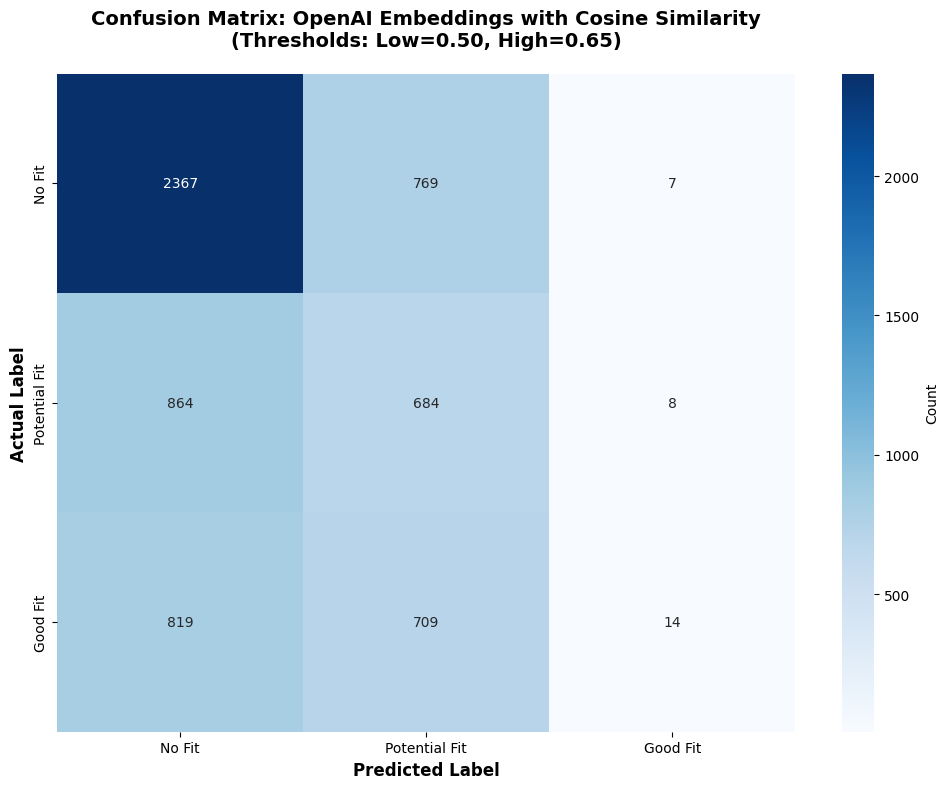

Confusion matrix visualization displayed.


In [21]:
# Visualize Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'}, ax=ax)
ax.set_title('Confusion Matrix: OpenAI Embeddings with Cosine Similarity\n(Thresholds: Low=0.50, High=0.65)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('Actual Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("Confusion matrix visualization displayed.")


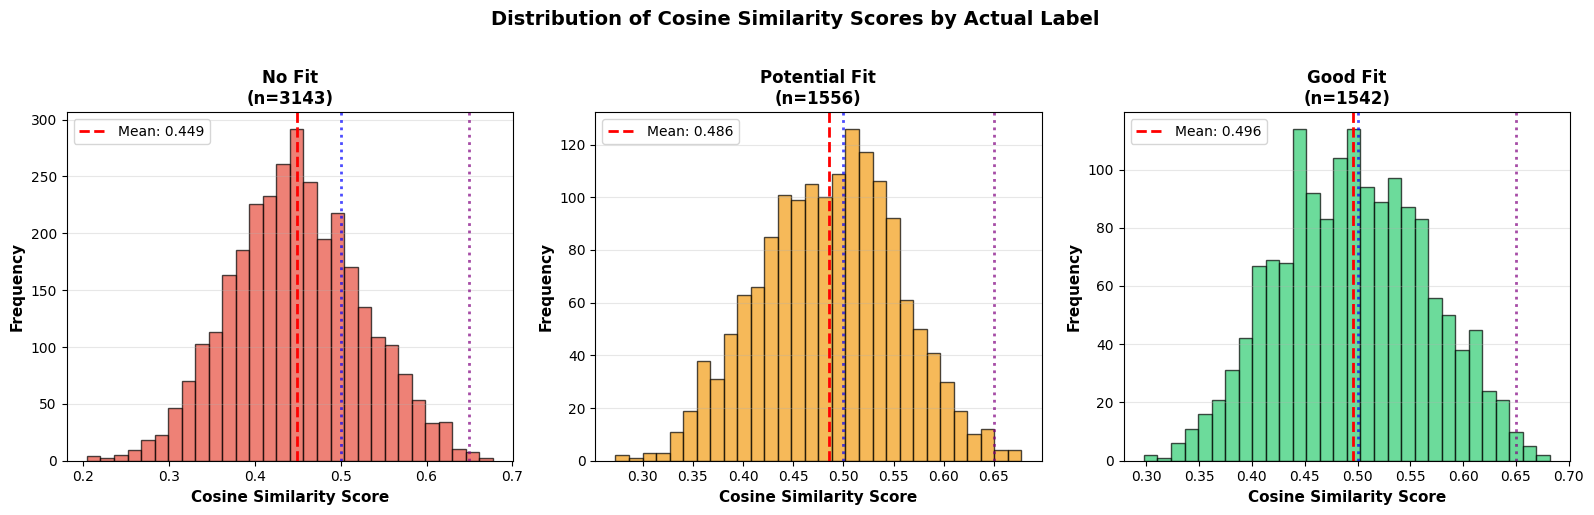

Similarity score distribution visualization displayed.


In [22]:
# Visualize similarity score distribution by actual label
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

labels_list = ['No Fit', 'Potential Fit', 'Good Fit']
colors = ['#e74c3c', '#f39c12', '#2ecc71']

for ax, label, color in zip(axes, labels_list, colors):
    label_scores = df_train[df_train['label'] == label]['cosine_similarity']
    ax.hist(label_scores, bins=30, color=color, alpha=0.7, edgecolor='black')
    ax.axvline(label_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {label_scores.mean():.3f}')
    ax.set_xlabel('Cosine Similarity Score', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(f'{label}\n(n={len(label_scores)})', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

# Add threshold lines
for ax in axes:
    ax.axvline(0.50, color='blue', linestyle=':', linewidth=2, alpha=0.7, label='Low Threshold')
    ax.axvline(0.65, color='purple', linestyle=':', linewidth=2, alpha=0.7, label='High Threshold')

plt.suptitle('Distribution of Cosine Similarity Scores by Actual Label',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Similarity score distribution visualization displayed.")


In [23]:
# Threshold tuning: Find optimal thresholds
print("="*60)
print("THRESHOLD TUNING ANALYSIS")
print("="*60 + "\n")

results_tuning = []

# Test different threshold combinations
for low_threshold in [0.40, 0.45, 0.50, 0.55, 0.60]:
    for high_threshold in [low_threshold + 0.10, low_threshold + 0.15, low_threshold + 0.20]:
        # Predict with current thresholds
        predictions = df_train['cosine_similarity'].apply(
            lambda x: predict_fit_label(x, threshold_low=low_threshold, threshold_high=high_threshold)
        )

        # Calculate metrics
        acc = accuracy_score(df_train['label'], predictions)
        f1 = f1_score(df_train['label'], predictions, average='macro')

        results_tuning.append({
            'Low_Threshold': low_threshold,
            'High_Threshold': high_threshold,
            'Accuracy': acc,
            'F1_Score': f1
        })

tuning_df = pd.DataFrame(results_tuning)
tuning_df = tuning_df.sort_values('F1_Score', ascending=False)

print("Top 10 Threshold Combinations (by F1-Score):")
print(tuning_df.head(10).to_string(index=False))

# Best thresholds
best_row = tuning_df.iloc[0]
print(f"\n✓ Best Thresholds Found:")
print(f"  Low Threshold: {best_row['Low_Threshold']:.2f}")
print(f"  High Threshold: {best_row['High_Threshold']:.2f}")
print(f"  F1-Score: {best_row['F1_Score']:.4f}")
print(f"  Accuracy: {best_row['Accuracy']:.4f}")


THRESHOLD TUNING ANALYSIS

Top 10 Threshold Combinations (by F1-Score):
 Low_Threshold  High_Threshold  Accuracy  F1_Score
          0.45            0.55  0.450729  0.415534
          0.50            0.60  0.498318  0.382962
          0.45            0.60  0.442557  0.370429
          0.40            0.50  0.357475  0.359575
          0.40            0.55  0.368851  0.356292
          0.50            0.65  0.491107  0.347968
          0.50            0.70  0.490146  0.342501
          0.45            0.65  0.435347  0.333796
          0.40            0.60  0.360679  0.308691
          0.55            0.65  0.494793  0.298323

✓ Best Thresholds Found:
  Low Threshold: 0.45
  High Threshold: 0.55
  F1-Score: 0.4155
  Accuracy: 0.4507


In [24]:
# Apply best thresholds and show final results
best_low = best_row['Low_Threshold']
best_high = best_row['High_Threshold']

print("\n" + "="*60)
print("FINAL RESULTS WITH OPTIMIZED THRESHOLDS")
print("="*60 + "\n")

df_train['predicted_label_optimized'] = df_train['cosine_similarity'].apply(
    lambda x: predict_fit_label(x, threshold_low=best_low, threshold_high=best_high)
)

# Final metrics
final_accuracy = accuracy_score(df_train['label'], df_train['predicted_label_optimized'])
final_precision = precision_score(df_train['label'], df_train['predicted_label_optimized'], average='macro')
final_recall = recall_score(df_train['label'], df_train['predicted_label_optimized'], average='macro')
final_f1 = f1_score(df_train['label'], df_train['predicted_label_optimized'], average='macro')

print(f"Optimized Thresholds: Low={best_low:.2f}, High={best_high:.2f}\n")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision (Macro): {final_precision:.4f}")
print(f"Recall (Macro): {final_recall:.4f}")
print(f"F1-Score (Macro): {final_f1:.4f}")

print("\n" + "-"*60)
print("CLASSIFICATION REPORT (Optimized)")
print("-"*60)
print(classification_report(df_train['label'], df_train['predicted_label_optimized']))

# Show sample predictions
print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60 + "\n")
sample_df = df_train[['resume_text', 'job_description_text', 'cosine_similarity',
                       'label', 'predicted_label_optimized']].head(10).copy()
sample_df['resume_text'] = sample_df['resume_text'].str[:50] + '...'
sample_df['job_description_text'] = sample_df['job_description_text'].str[:50] + '...'
print(sample_df.to_string(index=False))



FINAL RESULTS WITH OPTIMIZED THRESHOLDS

Optimized Thresholds: Low=0.45, High=0.55

Accuracy: 0.4507
Precision (Macro): 0.4399
Recall (Macro): 0.4263
F1-Score (Macro): 0.4155

------------------------------------------------------------
CLASSIFICATION REPORT (Optimized)
------------------------------------------------------------
               precision    recall  f1-score   support

     Good Fit       0.38      0.24      0.29      1542
       No Fit       0.64      0.52      0.57      3143
Potential Fit       0.30      0.52      0.38      1556

     accuracy                           0.45      6241
    macro avg       0.44      0.43      0.42      6241
 weighted avg       0.49      0.45      0.46      6241


SAMPLE PREDICTIONS

                                          resume_text                                    job_description_text  cosine_similarity  label predicted_label_optimized
SummaryHighly motivated Sales Associate with exten...   Net2Source Inc. is an award-winning tota